# Clasificación con Scikit-learn y MLflow

En esta primera parte de la práctica se desarrolla un proyecto de clasificación supervisada utilizando un conjunto de datos incluido en la librería Scikit-learn (en este caso, el dataset Wine). A lo largo del proceso, se siguen las etapas típicas de un flujo de trabajo en machine learning, desde la exploración inicial hasta el registro de experimentos, haciendo uso de MLflow para gestionar métricas e hiperparámetros, así como y comparar los diferentes resultados obtenidos.


In [1]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_wine

sys.path.append(os.path.abspath("../src"))
from mlflow_utils import load_data, split_data, train_model, evaluate_model, train_and_log_models

### Carga del dataset y análisis exploratorio

En esta sección se realiza la carga del dataset Wine y un primer análisis exploratorio de su contenido. El objetivo es familiarizarse con la estructura de los datos, identificar las variables disponibles, su tipo, posibles valores nulos y otras características relevantes que puedan influir en las decisiones de preprocesamiento y modelado posteriores.

Cargamos el dataset **Wine** directamente desde la librería `scikit-learn` utilizando la función `load_data()`.

Este conjunto de datos contiene información química de diferentes tipos de vino, y será utilizado para construir nuestro modelo de clasificación.


In [2]:
# Carga del dataset
df = load_data()
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [3]:
# Información básica del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

Se observa que el dataset contiene 178 muestras y 14 columnas. No hay presencia de valores nulos. 

Las variables predictoras son todas de tipo float64, y la columna target, que representa la clase de vino, es de tipo entero (int64).

Analizamos la estadística básicas de todas las variables numéricas del dataset. Esto permite tener una visión general de la distribución y rango de valores de cada atributo.

In [4]:
# Estadísticas descriptivas
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000



Todas las variables predictoras son numéricas continuas y presentan escalas diferentes, por lo que es necesario aplicar técnicas de **normalización o estandarización** antes del entrenamiento del modelo.

La **media y mediana** de muchas variables son similares, lo que sugiere una posible distribución simétrica. Sin embargo, variables como 'malic_acid' y 'color_intensity' presentan mayor dispersión, lo que podría indicar sesgos o colas más largas.

La variable objetivo ('target') toma valores enteros entre 0 y 2, esto define el problema como una **clasificación multiclase** con tres clases.


A continuación visualizamos la distribución de las variables.

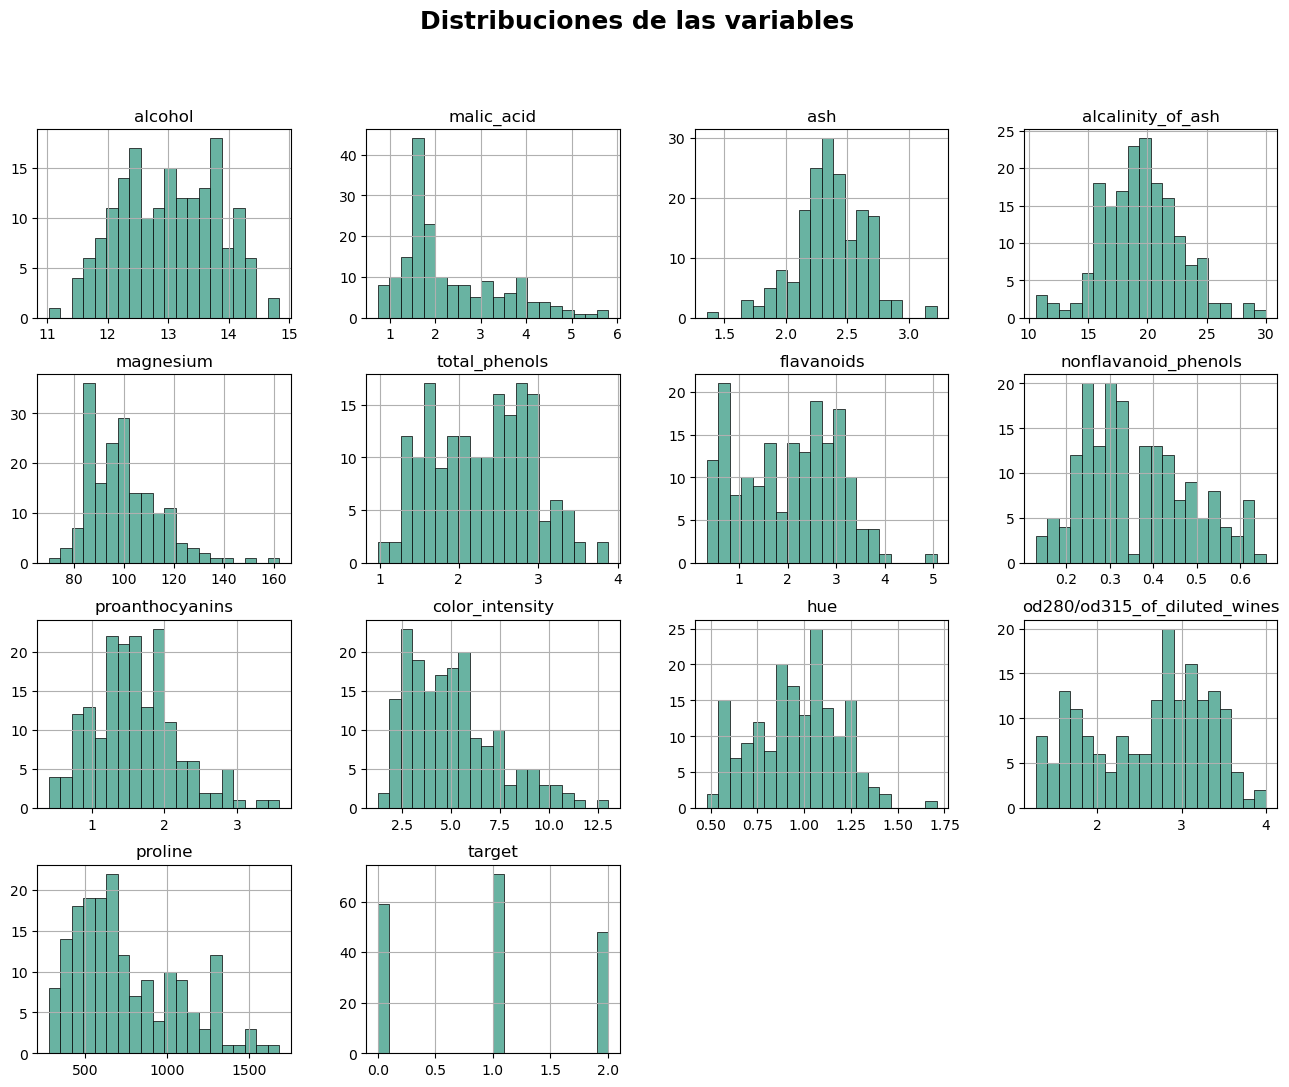

In [5]:
# Histograma de las variables
df.hist(
    bins=20,
    figsize=(16, 12),
    color="#69b3a2", 
    edgecolor='black',  
    linewidth=0.5
)
# Título general
plt.suptitle("Distribuciones de las variables", fontsize=18, fontweight='bold')
plt.show()

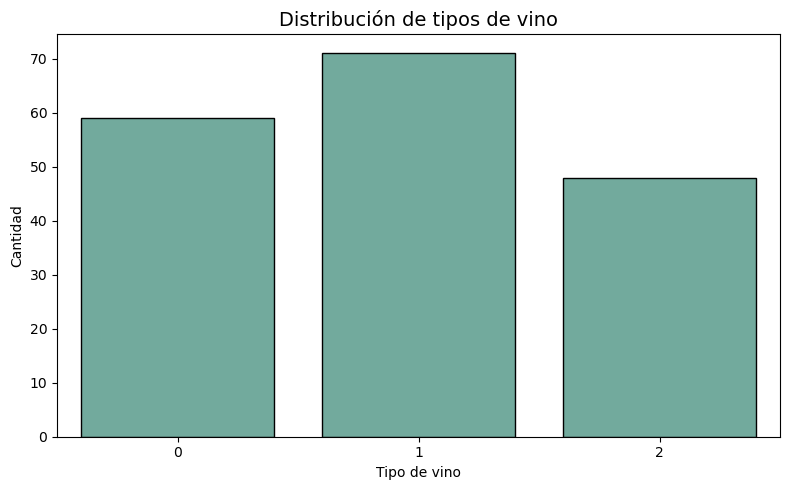

In [6]:
# Distribución de la variable objetivo 
plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=df, color='#69b3a2', edgecolor='black')

plt.title("Distribución de tipos de vino", fontsize=14)
plt.xlabel("Tipo de vino")
plt.ylabel("Cantidad")

plt.tight_layout()
plt.show()

La distribución entre las tres clases es relativamente equilibrada, lo que permitiría aplicar el modelo de clasificación sin necesidad inmediata de técnicas de balanceo.

Generamos un heatmap de correlaciones para visualizar las relaciones lineales entre las variables del dataset.

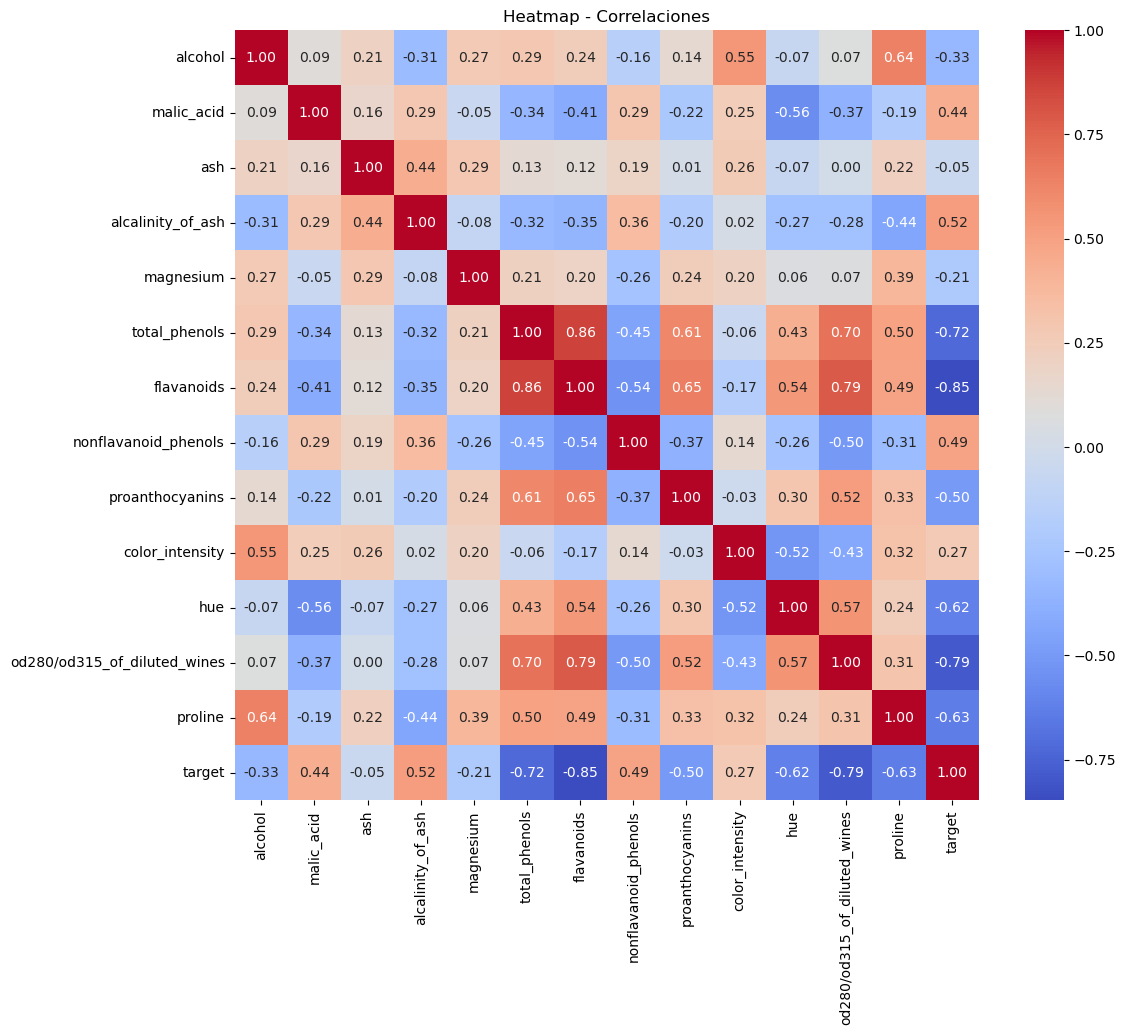

In [7]:
# Heatmap - correlaciones entre variables
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Heatmap - Correlaciones")
plt.show()

### Preprocesamieto y división de los datos

En esta etapa se aplica la función `preprocess_data()` para realizar la separación del dataset en tres subconjuntos:

- **X_train / y_train**: conjunto de entrenamiento, utilizado para ajustar el modelo.

- **X_val / y_val**: conjunto de validación, utilizado para ajustar hiperparámetros y prevenir overfitting.

- **X_test / y_test**: conjunto de prueba, para la evaluación final del rendimiento del modelo.

In [9]:
# División del dataset en conjuntos de entrenamiento, validación y prueba
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)

Tamaño de X_train: (113, 13)
Tamaño de X_val: (29, 13)
Tamaño de X_test: (36, 13)


### Entrenamiento y evaluación del modelo base

En este bloque se entrena un modelo base de clasificación utilizando `Gradient Boosting`.  
La función `train_model()` crea un pipeline compuesto por:

- Un escalado de características con `StandardScaler`
- Seguido del clasificador `GradientBoostingClassifier`

Una vez entrenado el modelo sobre el conjunto de entrenamiento, se evalúa su rendimiento en los conjuntos de entrenamiento (train) y prueba (test) mediante la función `evaluate_model()`, que calcula e imprime el accuracy para cada caso.

Este modelo proporciona una línea base de rendimiento, que servirá como referencia antes de realizar el ajuste de hiperparámetros.


In [11]:
# Entrenar modelo con hiperparámetros iniciales
model = train_model(X_train, y_train, n_estimators=100, max_depth=3, learning_rate=0.1)

# Evaluamos en train, val y test
accuracy_train = evaluate_model(model, X_train, y_train, dataset_name="train")
accuracy_val = evaluate_model(model, X_val, y_val, dataset_name="val")
accuracy_test = evaluate_model(model, X_test, y_test, dataset_name="test")


Accuracy en train: 1.000
Accuracy en val: 0.966
Accuracy en test: 0.944


In [12]:
# Mostramos los hiperparámetros del modelo entrenado
model.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('classifier', GradientBoostingClassifier(random_state=42))],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': GradientBoostingClassifier(random_state=42),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__criterion': 'friedman_mse',
 'classifier__init': None,
 'classifier__learning_rate': 0.1,
 'classifier__loss': 'log_loss',
 'classifier__max_depth': 3,
 'classifier__max_features': None,
 'classifier__max_leaf_nodes': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__n_estimators': 100,
 'classifier__n_iter_no_change': None,
 'classifier__random_state': 42,
 'classifier__subsample': 1.0,
 'classifier__tol': 0.0001,
 'classifier__validation_fraction': 0.1,
 'classifier__verbose': 0,
 '

### Ejecución de Experimentos y registro con MLflow

Para evaluar distintas combinaciones de hiperparámetros del modelo **Gradient Boosting**, utilizamos la función `train_and_log_models()`, que registra automáticamente los experimentos en MLflow.  
Cada run almacena:

- Los hiperparámetros usados: `n_estimators`, `max_depth`, `learning_rate`
- La métrica de entrenamiento y validación: `train_accuracy` y `val_accuracy`
- El modelo entrenado como artefacto


In [13]:
# Ejecutamos los experimentos desde el siguiente script:
!python ../src/run_experiments.py

Ejecutando entrenamiento con Gradient Boosting + MLflow
Tamaño de X_train: (113, 13)
Tamaño de X_val: (29, 13)
Tamaño de X_test: (36, 13)
Accuracy en train: 1.000
Accuracy en val: 0.966
2025/07/06 12:13:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Accuracy en train: 1.000
Accuracy en val: 0.966
2025/07/06 12:13:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Accuracy en train: 1.000
Accuracy en val: 0.966
2025/07/06 12:13:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Accuracy en train: 1.000
Accuracy en val: 0.966
2025/07/06 12:13:46 WARNING mlflow.models.model: Model logged without a signature 

Lanzamos la interfaz de MLflow desde la terminal de Jupyter Lab:

```bash
mlflow server



<img src="capturas/captura1.png" width="1200" align="center">

Accedemos a la interfaz de MLflow desde el navegador:  http://127.0.0.1:5000

Página principal del experimento `Wine_GradientBoosting_MLflow` en MLflow con todos los runs registrados:

<img src="capturas/captura2.png" width="1200" align="center">

Comparativa de varios runs en MLflow , mostrando hiperparámetros y métricas registradas:


<img src="capturas/captura3.1.png" width="1200" align="center">


<img src="capturas/captura3.2.png" width="1200" align="center">

Como todos los resultados han sido iguales, presentan el mismo valor de accuracy en train y val, vamos a elegir el primero run ejecutado por ejemplo, con run_name=n_estimators=100, max_depth=5, lr=0.1, para evaluar en test y registrarlo en MLflow.

Detalles del run selecionado como mejor run,  incluyendo los parámetros usados, la métrica obtenida y el modelo registrado como artefacto:



<img src="capturas/captura4.1.png" width="1200" align="center">


<img src="capturas/captura4.2.png" width="1200" align="center">


<img src="capturas/captura4.3.png" width="1200" align="center">


<img src="capturas/captura4.4.png" width="1200" align="center">

Visualización del gráfico generado en MLflow comparando la métrica `train_accuracy`  y `val_accuracy` entre los distintos runs del experimento:


<img src="capturas/captura5.1.png" width="900" align="center">


<img src="capturas/captura5.2.png" width="900" align="center">

In [12]:
# Entrenar modelo final seleccionado
best_model = train_model(X_train, y_train, n_estimators=100, max_depth=5, learning_rate=0.1)

# Evaluar en train y test
train_acc = evaluate_model(best_model, X_train, y_train, dataset_name="train")
test_acc = evaluate_model(best_model, X_test, y_test, dataset_name="test")


Accuracy en train: 1.000
Accuracy en test: 0.944


Resgitramos el modelo desde la interface de MLflow:


<img src="capturas/captura6.1.png" width="900" align="center">




<img src="capturas/captura6.2.png" width="1200" align="center">

# Despliegue de Algoritmos con FastAPI

En esta segunda parte de la práctica, el objetivo es desarrollar y documentar una **API REST** utilizando **FastAPI**, simulando un entorno real de despliegue de modelos o servicios inteligentes.

Para ello, se debe generar un script con al menos cinco endpoints (`@app.get`), incluyendo dos endpoints que utilicen pipelines de modelos preentrenados de Hugging Face (Transformers).

La API deberá estar correctamente documentada mediante **Swagger UI**, accesible desde la ruta `/docs`, y todas las funcionalidades deberán poder utilizarse tanto desde la interfaz web como desde peticiones HTTPS (por ejemplo, con `curl` o `Postman`).


### Estructura de la API

La API se ha implementado dentro de la carpeta `api/`, que contiene los siguientes archivos:

- `main.py`: Script principal con los endpoints de FastAPI.
- `requirements.txt`: Archivo con las dependencias necesarias para ejecutar la API.
- `Dockerfile`: Archivo de configuración para crear una imagen Docker y desplegar en Google Cloud Run.

### Ejecución en local la API con FastAPI

Se lanza el servidor Uvicorn desde la carpeta cdel proyecto, indicando la ruta al script que contiene la aplicación FastAPI:

```bash
cd api
uvicorn main:app --reload

Esto ejecutará la API en el puerto 8000, y podremos acceder a la interfaz Swagger UI desde: 
http://127.0.0.1:8000/docs

<img src="capturas/captura7.png" width="900" align="center">

<img src="capturas/captura8.png" width="1000" align="center">

Ahora probamos cada uno de los enpoints desde la interfaz Swagger UI: 

1. Endpoint raíz – Mensaje de bienvenida

<img src="capturas/captura9.1.png" width="1000" align="center">

2. sentiment – Análisis de Sentimiento (Hugging Face)


<img src="capturas/captura9.2.png" width="1000" align="center">

 3. summarize – Resumen de texto (Hugging Face)

<img src="capturas/captura9.3.png" width="1000" align="center">

4. hello – Saludo personalizado

ç<img src="capturas/captura9.4.png" width="1000" align="center">

5. add – Suma de dos números

<img src="capturas/captura9.5.png" width="1000" align="center">

6. multiply – Multiplicación de dos números

<img src="capturas/captura9.6.png" width="1000" align="center">

### Ejecución vía HTTP 

Una vez verificado el funcionamiento de los endpoints desde la interfaz interactiva `/docs`, realizamos peticiones HTTP directas utilizando herramientas externas como `curl` (desde la terminal).

A continuación se muestran las capturas de las pruebas realizadas junto con las respuestas obtenidas.


**Endpoints ejecutados con `curl`desde la terminal**


<img src="capturas/captura10.png" width="1000" align="center">
